In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

In [2]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # 0 = all messages, 1 = INFO, 2 = WARNING, 3 = ERROR

tf.get_logger().setLevel('ERROR')  # To further restrict logging

In [3]:
# Load dataset
df = pd.read_csv('/kaggle/input/pali-to-english/output_file.csv')

# Separate the input and target text
input_texts = df['input_text'].values
target_texts = df['target_text'].values

# Tokenization and padding (you can adjust max_length based on your data)
tokenizer_pali = tf.keras.preprocessing.text.Tokenizer()
tokenizer_english = tf.keras.preprocessing.text.Tokenizer()

tokenizer_pali.fit_on_texts(input_texts)
tokenizer_english.fit_on_texts(target_texts)

input_sequences = tokenizer_pali.texts_to_sequences(input_texts)
target_sequences = tokenizer_english.texts_to_sequences(target_texts)

max_len_input = max([len(seq) for seq in input_sequences])
max_len_target = max([len(seq) for seq in target_sequences])

input_sequences = tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=max_len_input, padding='post')
target_sequences = tf.keras.preprocessing.sequence.pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

# Vocabulary sizes
vocab_size_pali = len(tokenizer_pali.word_index) + 1
vocab_size_english = len(tokenizer_english.word_index) + 1

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(input_sequences, target_sequences[:, 1:], test_size=0.2, random_state=42)
target_sequences_input = target_sequences[:, :-1]


In [4]:
class Transformer(Model):
    def __init__(self, vocab_size_input, vocab_size_target, embed_dim, num_heads, ff_dim, num_layers, dropout_rate=0.1):
        super(Transformer, self).__init__()
        self.embedding_input = Embedding(vocab_size_input, embed_dim)
        self.embedding_target = Embedding(vocab_size_target, embed_dim)

        self.encoder_layers = [
            [MultiHeadAttention(num_heads, embed_dim // num_heads),
             LayerNormalization(epsilon=1e-6),
             Dense(ff_dim, activation='relu'),
             Dense(embed_dim),
             Dropout(dropout_rate)]
            for _ in range(num_layers)
        ]

        self.decoder_layers = [
            [MultiHeadAttention(num_heads, embed_dim // num_heads),
             MultiHeadAttention(num_heads, embed_dim // num_heads),
             LayerNormalization(epsilon=1e-6),
             Dense(ff_dim, activation='relu'),
             Dense(embed_dim),
             Dropout(dropout_rate)]
            for _ in range(num_layers)
        ]

        self.final_layer = Dense(vocab_size_target)

    def call(self, inputs, training=False):
        input_seq, target_seq = inputs
        input_embedding = self.embedding_input(input_seq)
        target_embedding = self.embedding_target(target_seq)

        x = input_embedding
        for mha, ln, ff1, ff2, drop in self.encoder_layers:
            attn_output = mha(x, x)
            x = ln(x + attn_output)
            ffn_output = ff2(ff1(x))
            x = drop(x + ffn_output, training=training)

        y = target_embedding
        for mha1, mha2, ln, ff1, ff2, drop in self.decoder_layers:
            attn_output1 = mha1(y, y)
            attn_output2 = mha2(attn_output1, x)
            y = ln(y + attn_output2)
            ffn_output = ff2(ff1(y))
            y = drop(y + ffn_output, training=training)

        return self.final_layer(y)


In [5]:

# Model parameters
embed_dim = 256  # Embedding size
num_heads = 8    # Number of attention heads
ff_dim = 512     # Feed-forward network size
num_layers = 4   # Number of encoder/decoder layers

transformer = Transformer(vocab_size_pali, vocab_size_english, embed_dim, num_heads, ff_dim, num_layers)

# Compile the model with accuracy metric
transformer.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

# Train the model for 10 epochs with a batch size of 16 and validation data
history = transformer.fit([X_train, target_sequences_input[:len(X_train)]],
                          y_train,
                          validation_data=([X_val, target_sequences_input[:len(X_val)]], y_val),
                          batch_size=16,  # or 32
                          epochs=10)


Epoch 1/10


I0000 00:00:1729267297.075072     430 service.cc:145] XLA service 0x7cbd04005b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729267297.075114     430 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729267297.075120     430 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1729267298.688137     430 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1729267311.003294     459 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_467', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1729267312.749803     457 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_427', 100 bytes spill stores, 100 bytes spill loads

I0000 00:00:172926731

6607/6608 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.9754 - loss: 0.3291

W0000 00:00:1729271181.042432     430 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1729271196.330581     572 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_473', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1729271197.098460     575 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_452', 1764 bytes spill stores, 1764 bytes spill loads

I0000 00:00:1729271197.744715     573 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_427', 100 bytes spill stores, 100 bytes spill loads

I0000 00:00:1729271200.380299     573 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_473', 332 bytes spill stores, 312 bytes spill loads

I0000 00:00:1729271204.110857   

6608/6608 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9754 - loss: 0.3291

W0000 00:00:1729271265.164791     431 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1729271270.234156     724 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_91', 100 bytes spill stores, 100 bytes spill loads

W0000 00:00:1729271615.179159     431 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1729271619.547911     740 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_95', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1729271620.218233     738 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_93', 332 bytes spill stores, 312 bytes spill loads

I0000 00:00:1729271622.128188     739 as

6608/6608 ━━━━━━━━━━━━━━━━━━━━ 4362s 646ms/step - accuracy: 0.9754 - loss: 0.3291 - val_accuracy: 0.9766 - val_loss: 0.2734
Epoch 2/10
6608/6608 ━━━━━━━━━━━━━━━━━━━━ 4131s 625ms/step - accuracy: 0.9768 - loss: 0.2721 - val_accuracy: 0.9766 - val_loss: 0.2726
Epoch 3/10
6608/6608 ━━━━━━━━━━━━━━━━━━━━ 4125s 624ms/step - accuracy: 0.9767 - loss: 0.2727 - val_accuracy: 0.9766 - val_loss: 0.2724
Epoch 4/10
6608/6608 ━━━━━━━━━━━━━━━━━━━━ 4124s 624ms/step - accuracy: 0.9768 - loss: 0.2710 - val_accuracy: 0.9766 - val_loss: 0.2727
Epoch 5/10
6608/6608 ━━━━━━━━━━━━━━━━━━━━ 4123s 624ms/step - accuracy: 0.9766 - loss: 0.2723 - val_accuracy: 0.9766 - val_loss: 0.2726
Epoch 6/10
6608/6608 ━━━━━━━━━━━━━━━━━━━━ 4119s 623ms/step - accuracy: 0.9767 - loss: 0.2712 - val_accuracy: 0.9766 - val_loss: 0.2720
Epoch 7/10
6608/6608 ━━━━━━━━━━━━━━━━━━━━ 4120s 623ms/step - accuracy: 0.9768 - loss: 0.2707 - val_accuracy: 0.9766 - val_loss: 0.2747
Epoch 8/10
6608/6608 ━━━━━━━━━━━━━━━━━━━━ 4115s 623ms/step - accur

In [6]:
# Evaluate on the validation set
val_loss, val_accuracy = transformer.evaluate([X_val, target_sequences_input[len(X_train):]], y_val)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


W0000 00:00:1729308707.066232     432 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1729308710.024011     938 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_80', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1729308710.110806     939 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_78', 332 bytes spill stores, 312 bytes spill loads

I0000 00:00:1729308711.654582     940 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_78', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1729308714.463001     941 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_88', 12 bytes spill stores, 12 bytes spill loads



825/826 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9768 - loss: 0.2700

W0000 00:00:1729309040.931836     432 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1729309045.469931     971 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_78', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1729309046.665442     969 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_78', 332 bytes spill stores, 312 bytes spill loads



826/826 ━━━━━━━━━━━━━━━━━━━━ 352s 404ms/step - accuracy: 0.9768 - loss: 0.2700
Validation Loss: 0.2718003988265991
Validation Accuracy: 0.9765858054161072


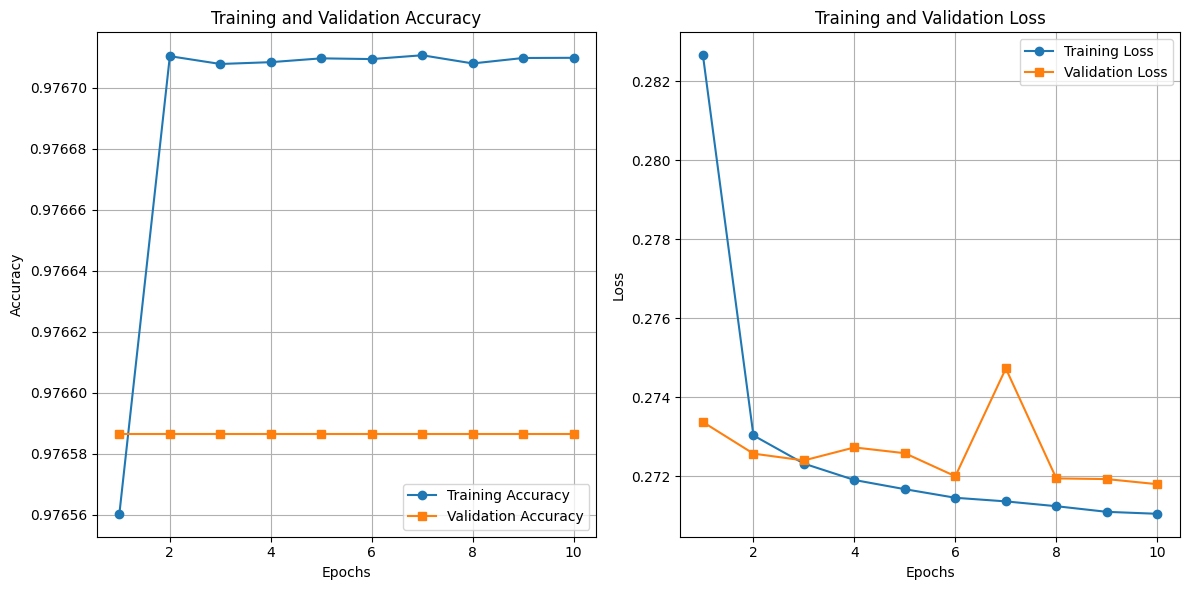

In [7]:

import matplotlib.pyplot as plt

# Extract data from history
epochs = range(1, len(history.history['accuracy']) + 1)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'o-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 's-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', label='Training Loss')
plt.plot(epochs, val_loss, 's-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()
